In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



2024-08-27 18:52:49.673214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 18:52:49.683288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 18:52:49.694392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 18:52:49.697534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 18:52:49.705363: I tensorflow/core/platform/cpu_feature_guar

In [2]:
USE_GPU = True
TRAIN = True

In [3]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724781170.958047   10935 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724781171.059853   10935 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724781171.061589   10935 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724781171.180020   10935 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
IMAGE_SIZE = 24
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.001
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100

In [5]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 22, 24), (2740,), (2740, 24, 24, 1))

In [6]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(24, 24, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 12, 12, 24)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 48)       │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 192)      │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 384)      │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 1)        │         1,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,057 (1.50 MB)

 Trainable params: 394,057 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=3, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=2, strides=1, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 1, 576)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 192)      │     1,769,472 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 192)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 96)       │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 48)       │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 24, 24, 24)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 24, 24, 24)     │         9,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │             

 Total params: 2,380,321 (9.08 MB)

 Trainable params: 2,379,649 (9.08 MB)

 Non-trainable params: 672 (2.62 KB)

In [8]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [9]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [10]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/55


I0000 00:00:1724781179.161739   24494 service.cc:146] XLA service 0x7a6108008ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724781179.161757   24494 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-08-27 18:52:59.464846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 18:53:00.526654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:16 38s/step - c_gp: 0.8019 - c_loss: 7.8814 - c_wass_loss: -0.1372 - g_loss: 0.2500

I0000 00:00:1724781210.080867   24494 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - c_gp: 0.5688 - c_loss: 5.2096 - c_wass_loss: -0.4781 - g_loss: 0.6863  

W0000 00:00:1724781241.015879   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.024322   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.024866   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.025410   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.025959   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.026513   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.027067   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.027633   10935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724781241.028186   10935 gp

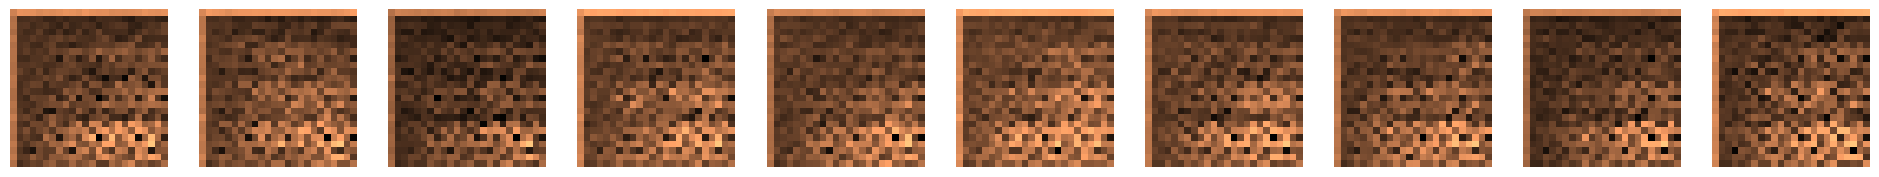

3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 16s/step - c_gp: 0.5210 - c_loss: 4.6238 - c_wass_loss: -0.5865 - g_loss: 0.8284
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/55


2024-08-27 18:54:01.394659: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-27 18:54:01.394695: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - c_gp: 0.2131 - c_loss: -7.2587 - c_wass_loss: -9.3899 - g_loss: 11.3760
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.3092 - c_loss: -10.0822 - c_wass_loss: -13.1743 - g_loss: 15.3253

2024-08-27 18:54:01.714135: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.3178 - c_loss: -9.7949 - c_wass_loss: -12.9730 - g_loss: 14.4966
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - c_gp: 0.3093 - c_loss: -8.2657 - c_wass_loss: -11.3582 - g_loss: 11.3881
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - c_gp: 0.2622 - c_loss: -7.2008 - c_wass_loss: -9.8232 - g_loss: 9.3068

2024-08-27 18:54:02.323738: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-27 18:54:02.323771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.2433 - c_loss: -6.9625 - c_wass_loss: -9.3957 - g_loss: 8.5396
Epoch 10/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.2106 - c_loss: -6.2706 - c_wass_loss: -8.3766 - g_loss: 6.1207

2024-08-27 18:54:02.627450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - c_gp: 0.2121 - c_loss: -6.0319 - c_wass_loss: -8.1531 - g_loss: 5.7843

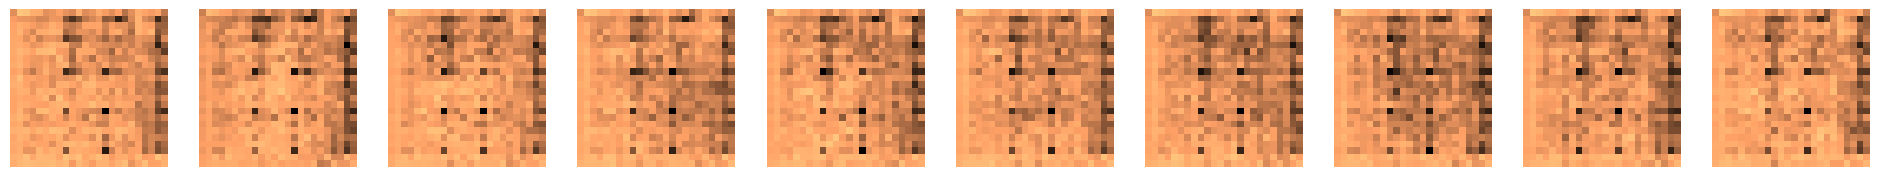

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - c_gp: 0.2091 - c_loss: -5.9947 - c_wass_loss: -8.0854 - g_loss: 5.7266
Epoch 12/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - c_gp: 0.1349 - c_loss: -5.4066 - c_wass_loss: -6.7560 - g_loss: 4.1580
Epoch 14/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - c_gp: 0.0599 - c_loss: -4.9806 - c_wass_loss: -5.5798 - g_loss: 3.7558

2024-08-27 18:54:03.336694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - c_gp: 0.0781 - c_loss: -4.9334 - c_wass_loss: -5.7143 - g_loss: 3.3515
Epoch 16/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - c_gp: 0.1560 - c_loss: -4.5773 - c_wass_loss: -6.1369 - g_loss: 1.6154

2024-08-27 18:54:03.645560: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-27 18:54:03.645590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.1298 - c_loss: -4.5677 - c_wass_loss: -5.8657 - g_loss: 1.8852
Epoch 18/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 19/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.1027 - c_loss: -4.3804 - c_wass_loss: -5.4073 - g_loss: 1.6343

2024-08-27 18:54:03.955450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.0989 - c_loss: -4.2799 - c_wass_loss: -5.2689 - g_loss: 1.3290
Epoch 20/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 21/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - c_gp: 0.0814 - c_loss: -3.9120 - c_wass_loss: -4.7263 - g_loss: 0.7765

2024-08-27 18:54:04.261802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.0836 - c_loss: -3.8896 - c_wass_loss: -4.7253 - g_loss: 0.6598

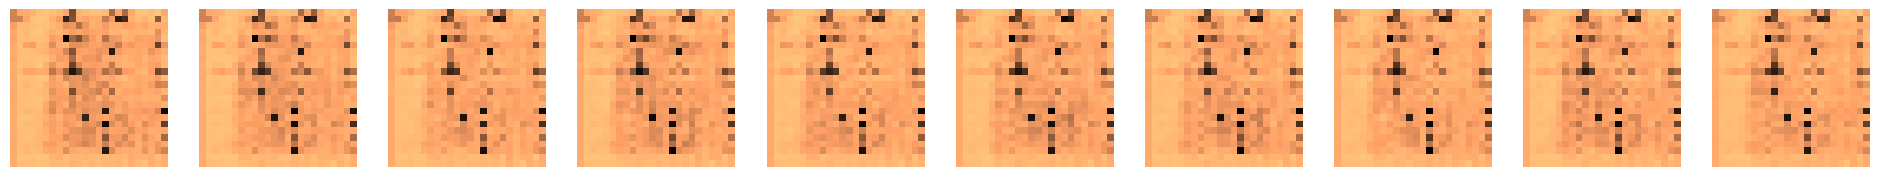

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - c_gp: 0.0864 - c_loss: -3.8711 - c_wass_loss: -4.7351 - g_loss: 0.6323
Epoch 22/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.0901 - c_loss: -3.5560 - c_wass_loss: -4.4567 - g_loss: 0.2543
Epoch 24/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - c_gp: 0.0765 - c_loss: -3.2528 - c_wass_loss: -4.0175 - g_loss: -0.0793
Epoch 26/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - c_gp: 0.0466 - c_loss: -2.9341 - c_wass_loss: -3.3999 - g_loss: -0.6095
Epoch 28/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_los

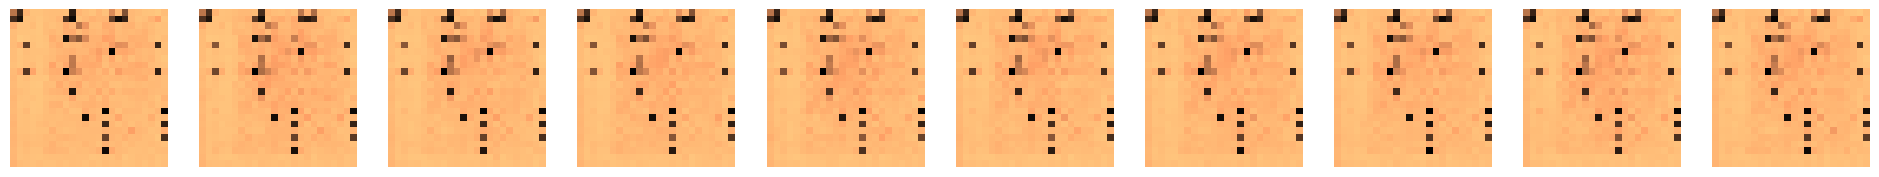

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - c_gp: 0.0504 - c_loss: -2.3304 - c_wass_loss: -2.8339 - g_loss: -1.3953
Epoch 32/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.0519 - c_loss: -2.3047 - c_wass_loss: -2.8240 - g_loss: -1.3010

2024-08-27 18:54:06.301814: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.0406 - c_loss: -2.2956 - c_wass_loss: -2.7014 - g_loss: -1.6190
Epoch 34/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.0456 - c_loss: -2.0739 - c_wass_loss: -2.5303 - g_loss: -1.9975

2024-08-27 18:54:06.614929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6637419883471115106


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - c_gp: 0.0369 - c_loss: -2.0375 - c_wass_loss: -2.4068 - g_loss: -2.0016
Epoch 36/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - c_gp: 0.0146 - c_loss: -1.9731 - c_wass_loss: -2.1186 - g_loss: -2.1829
Epoch 38/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 39/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - c_gp: 0.0313 - c_loss: -2.0151 - c_wass_loss: -2.3283 - g_loss: -2.5176
Epoch 40/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 41/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - c_gp: 0.0367 - c_loss: -1.8942 - c_wass_loss: -2.2616 - g_loss: -2.8244

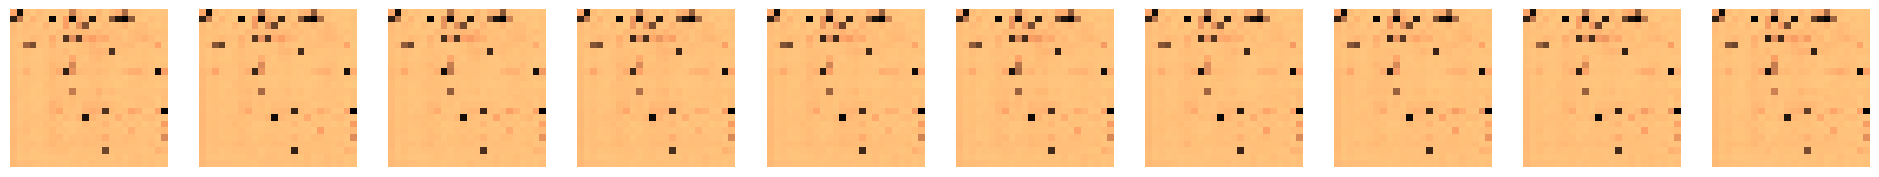

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - c_gp: 0.0349 - c_loss: -1.9037 - c_wass_loss: -2.2524 - g_loss: -2.7925
Epoch 42/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - c_gp: 0.0302 - c_loss: -2.0755 - c_wass_loss: -2.3773 - g_loss: -2.6135
Epoch 44/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - c_gp: 0.0278 - c_loss: -1.7212 - c_wass_loss: -1.9990 - g_loss: -0.9736
Epoch 46/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - c_gp: 0.0194 - c_loss: -1.7314 - c_wass_loss: -1.9254 - g_loss: -1.7713
Epoch 48/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_l

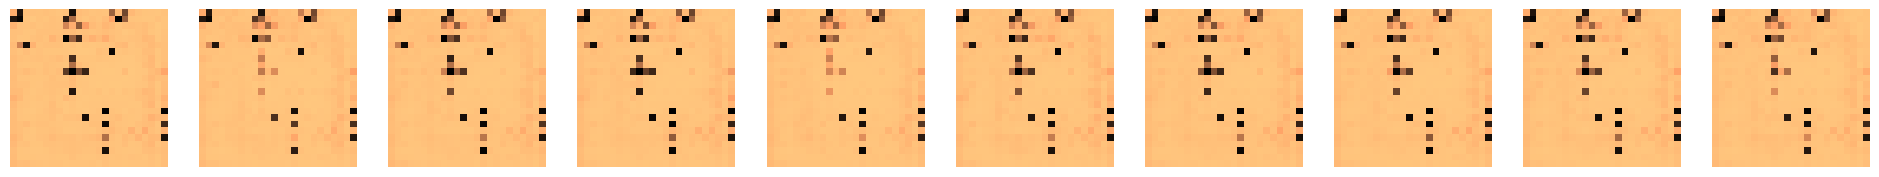

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - c_gp: 0.0290 - c_loss: -2.1329 - c_wass_loss: -2.4230 - g_loss: -4.3315
Epoch 52/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - c_gp: 0.0327 - c_loss: -1.8914 - c_wass_loss: -2.2185 - g_loss: -4.4736
Epoch 54/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - c_gp: 0.0316 - c_loss: -2.0256 - c_wass_loss: -2.3420 - g_loss: -2.4288


In [11]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
(100, 24, 24, 1)


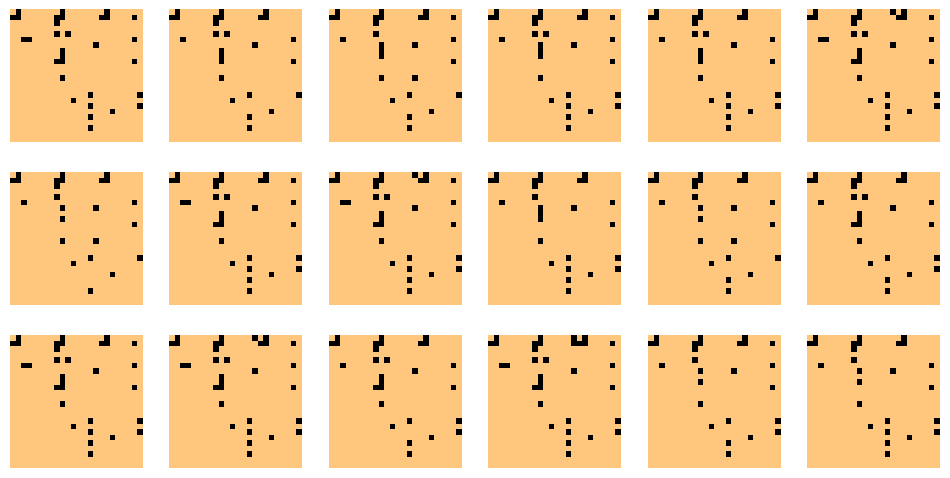

In [12]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_languages = generator.predict(noise)
    l = generated_languages.shape[0]

    # normalise
    generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
    # sigmoid
    generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_languages])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_languages.npz",
        generated_languages=generated_languages,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_languages.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]
    weirdness = data["weirdness"]
    l = generated_languages.shape[0]

print(generated_languages.shape)


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

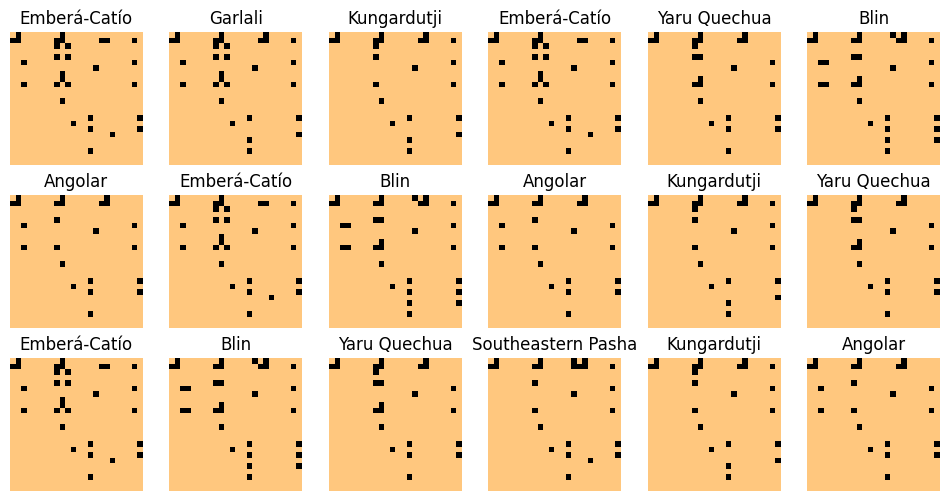

0.013697916666666667

In [13]:
# find closest matches

closest_idx, closest, closest_diff = get_closest_matches(X, generated_languages, n=NUM_LANGS)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

np.mean(closest_diff)

In [14]:
# find exact matches

exact_idx = get_exact_matches_indices(X, generated_languages)
exact = np.take(X, exact_idx)
exact_language_names = np.take(language_names_selected, exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

X.shape, exact_idx.shape

No exact matches. Noice!


((2740, 24, 24, 1), (0,))

In [15]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_pl_tbl_df.shape, cons_npl_tbl_df.shape, cons_coart_tbl_df.shape, vowels_tbl_df.shape

((14, 24), (7, 10), (3, 4), (7, 10))

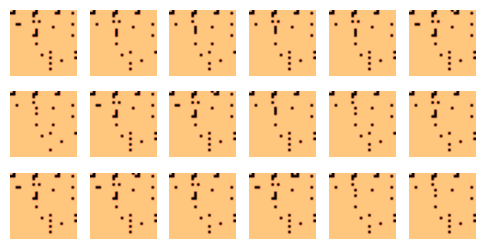

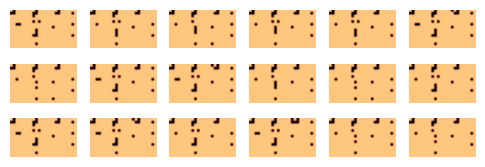

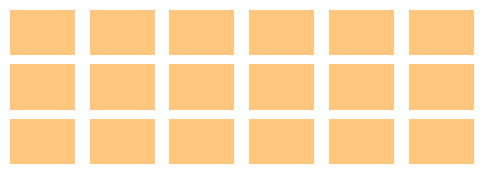

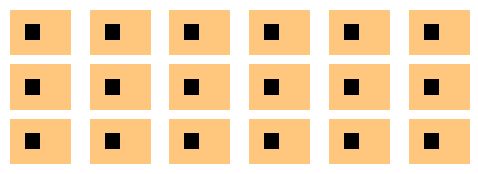

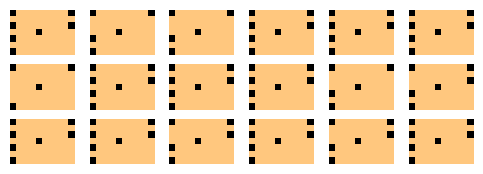

((100, 14, 24, 1), (100, 7, 10, 1), (100, 3, 4, 1), (100, 7, 10, 1))

In [16]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:10 :]
generated_cons_coart = generated_languages[:, 15:18, 10:14 :]
generated_vowels = generated_languages[:, 15:22, 14:24 :]

display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(6, 3))


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(6, 2))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [17]:
def create_ipa_table(lang, tbl, merge=False):
    phonemes = np.where(lang > 0, tbl.replace(np.nan, "*").replace("", "*"), np.full(lang.shape, "_")).astype(str)
    if merge is True:
        return pd.DataFrame(
            np.char.add(
                np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " / ")),
                phonemes[:,1::2]
            ), 
            index=tbl.index, 
            columns=tbl.columns[0::2]
        ).replace("_ / _", "")
    else:
        return pd.DataFrame(
            phonemes, 
            index=tbl.index, 
            columns=tbl.columns
        ).replace("_", "")
    
most_different = np.argmax(weirdness)
least_different = np.argmin(weirdness)


for idx in [most_different, least_different]:

    sample_cons_pl_tbl = create_ipa_table(np.squeeze(generated_cons_pl[idx]), cons_pl_tbl_df, merge=True)

    display(sample_cons_pl_tbl)

    sample_cons_npl_tbl = create_ipa_table(np.squeeze(generated_cons_npl[idx]), cons_npl_tbl_df)

    display(sample_cons_npl_tbl)

    sample_cons_coart_tbl = create_ipa_table(np.squeeze(generated_cons_coart[idx]), cons_coart_tbl_df)

    display(sample_cons_coart_tbl)

    sample_vowels_tbl = create_ipa_table(np.squeeze(generated_vowels[idx]), vowels_tbl_df)

    display(sample_vowels_tbl)

,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ / m,,,,_ / n,,,_ / ɲ,_ / ŋ,,,
Plosive,p / b,,,,t / d,,,_ / ɟ,k / ɡ,,,ʔ / _
Sibilant affricate,,,,,ts / _,,,,,,,
Non-sibilant affricate,,,,,,,,,,,,
Sibilant fricative,,,,,s / _,ʃ / _,,,,,,
Non-sibilant fricative,,f / v,,,,,,,,,,h / _
Approximant,,,,,,,,_ / j,,,,
Tap/flap,,,,,_ / ɾ,,,,,,,
Trill,,,,,_ / r,,,,,,,
Fricative,,,,,s / z,,,,,,,h / _


,Bilabial,Labiodental,Dental,Alveolar,Palato-alveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal
Ejective Stop,,,,,,,,,,
Ejective Fricative,,,,,,,,,,
Ejective Affricate,,,,,,,,,,
Ejective Lateral,,,,,,,,,,
Click,,,,,,,,,,
Implosive Voiced,,,,,,,,,,
Implosive Voiceless,,,,,,,,,,


,Labial–palatal,Labial–velar,Velarized alveolar,Palatal-velar
Fricative,,,,
Approximant,,w,,
Lateral approximant,,,,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,,,,,,,,,u
Near-close,,,,,,,,,,
Close-mid,e,,,,,,,,,o
Mid,,,,,ə,,,,,
Open-mid,ɛ,,,,,,,,,
Near-open,,,,,,,,,,
Open,a,,,,,,,,,


,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ / m,,,,_ / n,,,,_ / ŋ,,,
Plosive,p / b,,,,_ / d,t̠ / _,,,k / ɡ,,,
Sibilant affricate,,,,,,,,,,,,
Non-sibilant affricate,,,,,,,,,,,,
Sibilant fricative,,,,,s / _,,,,,,,
Non-sibilant fricative,,f / _,,,,,,,x / _,,,h / _
Approximant,,,,,_ / ɹ,,,_ / j,,,,
Tap/flap,,,,,,,,,,,,
Trill,,,,,_ / r,,,,,,,
Fricative,,,,,,,,,,,,h / _


,Bilabial,Labiodental,Dental,Alveolar,Palato-alveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal
Ejective Stop,,,,,,,,,,
Ejective Fricative,,,,,,,,,,
Ejective Affricate,,,,,,,,,,
Ejective Lateral,,,,,,,,,,
Click,,,,,,,,,,
Implosive Voiced,,,,,,,,,,
Implosive Voiceless,,,,,,,,,,


,Labial–palatal,Labial–velar,Velarized alveolar,Palatal-velar
Fricative,,,,
Approximant,,w,,
Lateral approximant,,,,


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,,,,,,,,,u
Near-close,,,,,,,,,,
Close-mid,,,,,,,,,,
Mid,,,,,ə,,,,,
Open-mid,,,,,,,,,,
Near-open,,,,,,,,,,
Open,,,,,,,,,,
